# Codes for Final Submission

In [2]:
### import module
import pandas as pd
import requests as rq
import numpy as np
from bs4 import BeautifulSoup as bsp
import time
import re
import ast
import math

### Creating folders for furture use

In [190]:
!mkdir img
!mkdir data

mkdir: img: File exists


## Scraping the BoxOffice Rankings
## And save them to seperate CSV files in the current dirrectory

### Notice: 
- Following web-scraping part would take a long time to run
- If you have the raw_final_data.csv in the current working folder, you could directly skip to analysis & visulization part

In [2]:
## get the rank and link to each individual movie for top 100 sales in China/NA/Global
for area in ["china","global","NorthAmerica"]:
    with open('mtime_data_'+area+'.txt', mode='w') as file:
        rank=1
        for page in range(10):
            parameters={"area":area,
                       "type":"MovieRankingHistory",
                       "category":"all",
                       "page":f'{page}',
                       "display":"list",
                       "timestamp":f'{time.time()}',
                       "version":"07bb781100018dd58eafc3b35d42686804c6df8d",
                       "dataType":"json"}
            try:
                MtimeRank = rq.get("http://movie.mtime.com/boxoffice/",params=parameters,timeout=10)
            except:
                print(f'Page {page} of area {area} for the MTime Boxoffice connection timeout')
                continue
                
            if MtimeRank.status_code!=200:
                print(f'Page {page} of area {area} for the MTime Boxoffice failed connection.')
                continue

            soup=bsp(MtimeRank.json()['html'])
            basic_info=soup.find_all("div",{"class":"txtbox"})
        
            for info in basic_info:
                for i in info.contents:
                    if i.name !="b":
                        if i.name == 'h3':
                            ## creating a personal split symbol "--;" for convenience
                            file.write('{}--;'.format(rank))
                            id_name=str(i.contents)
                            file.write('{}--;'.format(re.search("http.+[0-9]+\"",id_name).group(0)[:-1]))
                            file.write('{}--;'.format(re.search("\>.+\<",id_name).group(0)[1:-1]))
                        else:
                            file.write('{}--;'.format(i.text))
                for j in list(info.next_siblings):
                    for k in j.contents:
                        file.write('{}--;'.format(k.text))
                file.write('\n')
                # increase the rank and go to next moive
                rank+=1
        file.flush()

#### notice that sales in china is in CNY while its USD for global & NA
#### see if crutial information has been scraped

In [3]:
## see if crutial information has been scraped 
for area in ["china","global","NorthAmerica"]:
    with open('mtime_data_'+area+'.txt', mode='r') as file:
        contents=file.read()
    assert len(re.findall("http",contents))==100
    ## check scraped information for a movie
    basic_info=[]
    info_size=[]
    with open('mtime_data_'+area+'.txt', mode='r') as file:
        for line in file:
            basic=line.strip("\n--;").split("--;")
            basic_info.append(basic)
            info_size.append(len(basic))
    # output a sample basic information
    for i in basic_info:
        if len(i)==max(info_size):
            output=i
        break
    print(output)

['1', 'http://movie.mtime.com/229733', '战狼2', 'Wolf Warriors Ⅱ', '首日1.02亿|首周9.97亿|连冠4周', '2017年07月27日上映\xa02D/3D/IMAX', '导演：吴京', '主演：吴京/弗兰克·格里罗', '发行公司：北京京西文化旅游股份有限公司...', '7.4', '17010人评分', '56.82亿', '累计人次：1.60亿']
['1', 'http://movie.mtime.com/45997', '阿凡达', 'Avatar', '2009年12月17日英国上映\xa02D/3D/IMAX', '导演：詹姆斯·卡梅隆', '主演：萨姆·沃辛顿/佐伊·索尔达娜', '发行公司：中影...', '8.8', '68014人评分', '27.88亿']
['1', 'http://movie.mtime.com/192895', '星球大战：原力觉醒', 'Star Wars: The Force Awakens', '首日1.19亿|首周3.91亿', '2015年12月18日美国上映\xa02D/3D/IMAX3D', '导演：J·J·艾布拉姆斯', '主演：黛茜·雷德利/约翰·波耶加', '发行公司：中影...', '7.6', '9138人评分', '9.37亿']


### enter the page of each individual movie in the ranking list

In [4]:
#### for each of three top 100 sales
data=[]
area=["china","global","NorthAmerica"]
for i in area:
    with open("mtime_data_"+i+".txt",mode='r') as file:
        for line in file:
            data.append(i+' '+re.sub(r'(\xa0)|\n','',line))
### basic data frame
movie_name=[]
movie_eng=[]
link=[]
mtime_rate=[]
rate_users=[]
box_office=[]
BoxOfficeDetail=[]
ReleaseDate=[]
BoxOfficeRankCN=[]
BoxOfficeRankG=[]
BoxOfficeRankNA=[]
for i in data:
    infor=i.split(r"--;")
    movie_name.append(infor[2])
    movie_eng.append(infor[3])
    link.append(infor[1])
    
    if "首" in infor[4]:
        BoxOfficeDetail.append(infor[4])
    else:
        BoxOfficeDetail.append(np.NaN)
        
    ReleaseDate.append(re.search(r"\d+年\d+月\d+日\w*上映",i).group().replace("上映",""))
    
    
    sale_rate_txt=re.search(r"--;\d\.\d--;\d+人评分--;.+--;",i).group()
    sale_rate=re.sub(r"累计人次.+","",sale_rate_txt).split("--;")
    mtime_rate.append(sale_rate[1])
    rate_users.append(sale_rate[2].replace("人评分",""))
    
    if "china" in infor[0]:
        BoxOfficeRankCN.append(infor[0].replace("china ",""))
        BoxOfficeRankG.append(np.NaN)
        BoxOfficeRankNA.append(np.NaN)
        box_office.append(sale_rate[-2]+"CNY")
    elif "global" in infor[0]:
        BoxOfficeRankG.append(infor[0].replace("global ",""))
        box_office.append(sale_rate[-2]+"USD")
        BoxOfficeRankCN.append(np.NaN)
        BoxOfficeRankNA.append(np.NaN)
    elif "NorthAmerica" in infor[0]:
        BoxOfficeRankNA.append(infor[0].replace("NorthAmerica ",""))
        box_office.append(sale_rate[-2]+"USD")
        BoxOfficeRankG.append(np.NaN)
        BoxOfficeRankCN.append(np.NaN)
dat={"Name":movie_name,"NameEng":movie_eng,"MtimePage":link,"ReleaseDate":ReleaseDate,"BoxOffice":box_office,
     "BoxOfficeDetail":BoxOfficeDetail,"BoxOfficeRankCN":BoxOfficeRankCN,"BoxOfficeRankNA":BoxOfficeRankNA,
     "BoxOfficeRankG":BoxOfficeRankG,"MtimeRating":mtime_rate,
    "NumberofReviewers":rate_users}
dt=pd.DataFrame.from_dict(dat)
dt.head()

,Name,NameEng,MtimePage,ReleaseDate,BoxOffice,BoxOfficeDetail,BoxOfficeRankCN,BoxOfficeRankNA,BoxOfficeRankG,MtimeRating,NumberofReviewers
0,战狼2,Wolf Warriors Ⅱ,http://movie.mtime.com/229733,2017年07月27日,56.82亿CNY,首日1.02亿|首周9.97亿|连冠4周,1,NaN,NaN,7.4,17010
1,流浪地球,The Wandering Earth,http://movie.mtime.com/218707,2019年02月05日,46.20亿CNY,首日1.88亿|首周19.98亿|连冠2周,2,NaN,NaN,7.9,12103
2,红海行动,Operation Red Sea,http://movie.mtime.com/240425,2018年02月16日,36.51亿CNY,首日1.29亿|首周4.65亿,3,NaN,NaN,8.1,10175
3,唐人街探案2,Detective Chinatown 2,http://movie.mtime.com/234873,2018年02月16日,33.98亿CNY,首日3.41亿|首周9.90亿,4,NaN,NaN,7.0,5830
4,美人鱼,The Mermaid,http://movie.mtime.com/209007,2016年02月08日,33.92亿CNY,首日2.72亿|首周18.18亿|连冠2周,5,NaN,NaN,7.4,18216


### There certainly will be overlapping among three ranking lists

In [5]:
## fill in rankings
for i in data:
    infor=i.split(r"--;")
    if "china" in infor[0]:
        dt.loc[dt.Name==infor[2],"BoxOfficeRankCN"]=infor[0].replace("china ","")
    elif "global" in infor[0]:
        dt.loc[dt.Name==infor[2],"BoxOfficeRankG"]=infor[0].replace("global ","")
    elif "NorthAmerica" in infor[0]:
        dt.loc[dt.Name==infor[2],"BoxOfficeRankNA"]=infor[0].replace("NorthAmerica ","")
## fill in Global sales
dt_global=dt.iloc[100:200,[0,4]]
dt_global=dt_global.rename(columns={'BoxOffice':'BoxOfficeGlobal'})
dt_merged=pd.merge(dt,dt_global,how="left")

### Get Runtime, Genre(catergory), FilmFormat for each movie

In [6]:
# more basic information for each movie
Runtime=[]
Genre=[]
FilmFormat=[]
for i in dt_merged.MtimePage:
    try:
        detailpage=rq.get(i,timeout=10)
    except:
        print(f'{i} Time out')
    if detailpage.status_code==200:
        soup=bsp(detailpage.text,"lxml")
    else:
        print(f'{i} connection failed')
        continue

    ## Runtime, Genre(catergory), FilmFormat
    more_infor=soup.body.find_all("div",{"class":"otherbox"})
    if more_infor:
        more_infor_list=more_infor[0].text.split("-")
        try:
            Runtime.append(more_infor_list[0].strip())
        except:
            Runtime.append(np.NaN)
        try:
            Genre.append(more_infor_list[1].strip())
        except:
            Genre.append(np.NaN)
        try:
            FilmFormat.append(more_infor_list[3].strip())
        except:
            FilmFormat.append(np.NaN)
    else:
        Runtime.append(np.NaN)
        Genre.append(np.NaN)
        FilmFormat.append(np.NaN)
dt_merged["Runtime"]=Runtime
dt_merged["Genre"]=Genre
dt_merged["FilmFormat"]=FilmFormat

### Get actor names and staff members including writers, directors....

In [7]:
## actor/ staff member
## 演、职员
actor_staff=[]
for i in dt_merged.MtimePage:
    try:
        detailpage=rq.get(i+"/fullcredits.html",timeout=10)
    except:
        print(f'{i} Time out')
    if detailpage.status_code==200:
        soup=bsp(detailpage.text,"lxml")
    else:
        print(f'{i} connection failed')
        continue

    soup=bsp(detailpage.text,"lxml")
    actor_sec=soup.body.find_all("div",{"class":"actor_tit"})
    people={}
    actor_name=[]
    for i in actor_sec:
        if i.h4:
            actor=i.h4.text.strip()
        else:
            actor_name.append(i.text.strip())
    people[actor]=actor_name 
    ## Staff member
    staff_sec=soup.body.find_all("div",{"class":"credits_r"})[0].find_all("div",{"class":"credits_list"})
    for i in staff_sec:
        title=(i.h4.text.strip())
        member_list=[]
        member=i.find_all('p')
        if member:
            for p in member:
                member_list.append(p.text.strip())
        people[title]=member_list
    actor_staff.append(people)
dt_merged["ActorAndStaff"]=actor_staff

### Get winning awards for each movie

In [8]:
awards_detail=[]
awards_sum=[]
## add awards
## 奖项
for i in dt_merged.MtimePage:
    try:
        detailpage=rq.get(i+"/awards.html",timeout=10)
    except:
        print(f'{i} Time out')
    if detailpage.status_code==200:
        soup=bsp(detailpage.text,"lxml")
    else:
        print(f'{i} connection failed')
        continue
        
    award_name=soup.body.find_all("h3")
    award_detail=soup.body.find_all("dl")
    if award_name:
        aw_names=[]
        for i in award_name:
            if i.b:
                aw_names.append(i.text.strip())
            else:
                award_summary=i.text.strip()
            
        for i in range(len(award_detail)):
            if 'id' in award_detail[i].attrs:
                if award_detail[i]['id']=="awardSlidesItems":
                    position=i+1
                    break
        details=award_detail[position:]
        assert len(details)==len(aw_names)
        
        ## for each award, get detail
        award_dict=dict()
        for i in range(len(aw_names)):
            summary=re.search(r'奖 \(.+',aw_names[i])
            if summary:
                summary=summary.group().replace(r"奖 ","")
            name=re.search(r'\w+奖',aw_names[i])
            if name:
                name=name.group()
                award_dict[name]=[summary,re.sub(r'·\w+-','#',details[i].text.strip())]
            
        awards_sum.append([award_summary,aw_names])
        awards_detail.append(award_dict) 
    else:
        award_summary=np.NaN
        awards_sum.append(np.NaN)
        awards_detail.append(np.NaN) 
dt_merged["AwardSummary"]=awards_sum
dt_merged["AwardDetail"]=awards_detail

### Get Companies & Distributors for each movie

In [9]:
## add companies
## 公司
produce_company=[]
distribute_company=[]
for i in dt_merged.MtimePage:
    try:
        detailpage=rq.get(i+"/details.html",timeout=10)
    except:
        print(f'{i} Time out')
    if detailpage.status_code==200:
        soup=bsp(detailpage.text,"lxml")
    else:
        print(f'{i} connection failed')
        continue
    
    soup=bsp(detailpage.text,"lxml")
    company_sec=soup.body.find_all("dl",{"id":"companyRegion"})
    if company_sec:
        company_detail=company_sec[0].find_all("div",{"class":"fl wp49"})
        if company_detail:
            try:
                produce_company.append(company_detail[0].text)
            except:
                produce_company.append(np.NaN)
            try:
                distribute_company.append(company_detail[1].text)
            except:
                distribute_company.append(np.NaN)
    else:
        produce_company.append(np.NaN)
        distribute_company.append(np.NaN) 
dt_merged["ProductionCompany"]=produce_company
dt_merged["DistributorCompany"]=distribute_company

### Scraping finished, save the data to a CSV file

In [ ]:
dt_merged.to_csv("data/raw_final_data.csv")
dt_merged.head()

# Data Manipulation & Analysis

In [299]:
### read the data
dt=pd.read_csv("data/raw_final_data.csv")
dt=dt.drop(dt.columns[0], axis=1)

## Check missing values

In [195]:
dt.isna().sum()

Name                    0
NameEng                 1
MtimePage               0
ReleaseDate             0
BoxOffice               0
BoxOfficeDetail       124
BoxOfficeRankCN       160
BoxOfficeRankNA       110
BoxOfficeRankG        102
MtimeRating             0
NumberofReviewers       0
BoxOfficeGlobal       102
Runtime                 0
Genre                   0
FilmFormat             76
ActorAndStaff           0
AwardSummary           63
AwardDetail            63
ProductionCompany       0
DistributorCompany      6
dtype: int64

In [196]:
## some null values could be manually fixed
# dt[dt.NameEng.isna()]
dt.loc[185,"NameEng"]=2012
# double check 
dt.loc[185]

Name                                                               2012
NameEng                                                            2012
MtimePage                                  http://movie.mtime.com/80706
ReleaseDate                                               2009年11月13日美国
BoxOffice                                                      7.70亿USD
BoxOfficeDetail                                                     NaN
BoxOfficeRankCN                                                     NaN
BoxOfficeRankNA                                                     NaN
BoxOfficeRankG                                                       86
MtimeRating                                                           8
NumberofReviewers                                                 44384
BoxOfficeGlobal                                                7.70亿USD
Runtime                                                           158分钟
Genre                                                          动

## Check data types and convert to correct data types

In [197]:
## check data types and convert to correct data types
dt.dtypes

Name                   object
NameEng                object
MtimePage              object
ReleaseDate            object
BoxOffice              object
BoxOfficeDetail        object
BoxOfficeRankCN       float64
BoxOfficeRankNA       float64
BoxOfficeRankG        float64
MtimeRating           float64
NumberofReviewers       int64
BoxOfficeGlobal        object
Runtime                object
Genre                  object
FilmFormat             object
ActorAndStaff          object
AwardSummary           object
AwardDetail            object
ProductionCompany      object
DistributorCompany     object
dtype: object

In [198]:
## date to date 
dt.ReleaseDate=dt.ReleaseDate.apply(lambda x: re.sub(r"日\w*","",x))
dt.ReleaseDate=dt.ReleaseDate.apply(lambda x: re.sub(r"年|月","-",x))
dt.ReleaseDate=pd.to_datetime(dt.ReleaseDate)

## Recall that different units existed in the datasets

In [199]:
## Boxoffice/BoxofficeGlobal to float, and currency conversion, unit unified to million USD
BoxOffice=[]
BoxOfficeCN=[]
BoxOfficeNA=[]
money_local=dt.BoxOffice.apply(lambda x: float(re.sub(r"(亿USD)|(亿CNY)","",x)))
for i in range(len(dt.BoxOffice)):
    if "USD" in dt.BoxOffice[i]:
        BoxOffice.append(round(money_local[i]*100,6))
    else:
        BoxOffice.append(round(0.15*money_local[i]*100,6))
BoxOfficeGlobal=[]
for i in range(len(dt.BoxOffice)):
    x=dt.BoxOfficeGlobal[i]
    try:
        math.isnan(x)
        BoxOfficeGlobal.append(np.NaN)
    except:
        BoxOfficeGlobal.append(re.sub(r"亿USD","",x))
BoxOfficeGlobal=[round(float(i)*100,6) for i in BoxOfficeGlobal]
dt.BoxOffice=BoxOffice
dt.BoxOfficeGlobal=BoxOfficeGlobal

## For those scraped information that were original stored in the list/dictionary format
## We need to convert them back

In [200]:
## use ast to convert str representation of lists/dictionary back to their format
AwardSummary=[]
for i in dt.AwardSummary:
    try:
        math.isnan(i)
        AwardSummary.append(np.NaN)
    except:
        AwardSummary.append(ast.literal_eval(i))
ActorAndStaff=[]
for i in dt.ActorAndStaff:
    try:
        math.isnan(i)
        ActorAndStaff.append(np.NaN)
    except:
        ActorAndStaff.append(ast.literal_eval(i))
AwardDetail=[]
for i in dt.AwardDetail:
    try:
        math.isnan(i)
        AwardDetail.append(np.NaN)
    except:
        AwardDetail.append(ast.literal_eval(i))
dt.ActorAndStaff=ActorAndStaff
dt.AwardDetail=AwardDetail
dt.AwardSummary=AwardSummary

## There is a missing value in the Runtime that can be manually corrected

In [201]:
## Runtime to int
dt.Runtime=dt.Runtime.apply(lambda x: re.sub(r"分钟","",x))
## double check
check=dt.Runtime.apply(lambda x: re.sub(r"\d+",'0',x))
check[check!="0"]

295    喜剧
Name: Runtime, dtype: object

In [202]:
dt.iloc[295]

Name                                                            拜见岳父大人2
NameEng                                                Meet the Fockers
MtimePage                                  http://movie.mtime.com/18986
ReleaseDate                                         2004-12-22 00:00:00
BoxOffice                                                           279
BoxOfficeDetail                                                     NaN
BoxOfficeRankCN                                                     NaN
BoxOfficeRankNA                                                      96
BoxOfficeRankG                                                      NaN
MtimeRating                                                         7.2
NumberofReviewers                                                  2406
BoxOfficeGlobal                                                     NaN
Runtime                                                              喜剧
Genre                                                   2004年12月

In [203]:
## mannual clean: Meet the Fockers2, runtime 1h55m, genre Comedy (喜剧)
dt.iloc[295,13]=dt.iloc[295,12]
dt.iloc[295,12]="115"
## Runtime to int
dt.Runtime=dt.Runtime.apply(lambda x: re.sub(r"分钟","",x))
dt=dt.astype({"Runtime":int})

## For missing values in those three rankings, change them to 0 rather than NULL

In [204]:
dt.BoxOfficeRankCN=dt.BoxOfficeRankCN.fillna(0)
dt.BoxOfficeRankNA=dt.BoxOfficeRankNA.fillna(0)
dt.BoxOfficeRankG=dt.BoxOfficeRankG.fillna(0)
dt=dt.astype({"BoxOfficeRankCN":int,"BoxOfficeRankNA":int,"BoxOfficeRankG":int})

## For missing values in global sales, use domestic sales to represent

In [205]:
# fill in null in BoxOfficeGlobal with values in BoxOffice
dt.BoxOfficeGlobal=dt.BoxOfficeGlobal.fillna(value=dt.BoxOffice)

## Cleaning the extra texts in the information of two company columns

In [206]:
# remove extra text in companies
dt.ProductionCompany=dt.ProductionCompany.apply(lambda x: re.sub(r"制作公司 ","",x))
DistributorCompany=[]
for i in range(len(dt.DistributorCompany)):
    x=dt.DistributorCompany[i]
    try:
        math.isnan(x)
        DistributorCompany.append(np.NaN)
    except:
        DistributorCompany.append(re.sub(r"发行公司 ","",x))
dt.DistributorCompany=DistributorCompany

## Extract year & month and different genres in the data

In [207]:
## create year & month column
dt["Year"]=dt.ReleaseDate.apply(lambda x: x.year)
dt["Month"]=dt.ReleaseDate.apply(lambda x: x.month)
## seperate genres
unique_genere=set(dt.Genre.str.split(r"/").sum())
for g in unique_genere:
    dt[g]=dt.Genre.str.contains(g,regex=False)

In [208]:
## Check the data type again
dt.to_csv("data/Cleaned_data.csv")
dt.dtypes

Name                          object
NameEng                       object
MtimePage                     object
ReleaseDate           datetime64[ns]
BoxOffice                    float64
BoxOfficeDetail               object
BoxOfficeRankCN                int64
BoxOfficeRankNA                int64
BoxOfficeRankG                 int64
MtimeRating                  float64
NumberofReviewers              int64
BoxOfficeGlobal              float64
Runtime                        int64
Genre                         object
FilmFormat                    object
ActorAndStaff                 object
AwardSummary                  object
AwardDetail                   object
ProductionCompany             object
DistributorCompany            object
Year                           int64
Month                          int64
冒险                              bool
恐怖                              bool
剧情                              bool
家庭                              bool
科幻                              bool
犯

# Visulization 
### Note that Visulization in Matplotlib does not support Chinese Characters 
### Use the following to figure out the settings

In [209]:
## figuring out chinese output in matplot
# matplotlib.matplotlib_fname()
import matplotlib 
from matplotlib.font_manager import _rebuild
_rebuild()
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.serif'] = ['SimHei']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

## Creating subsets for different areas

In [210]:
dt_global=dt.iloc[100:200]
dt_cn=dt.iloc[0:100]
dt_na=dt.iloc[200:300]

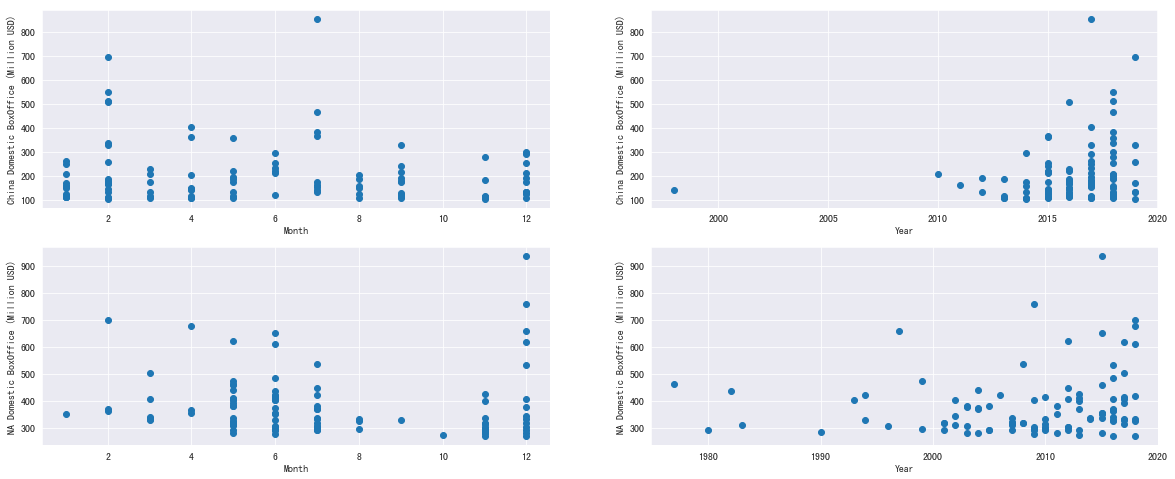

In [211]:
## Scatter Plots on domestic sales between China and North America
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,8))
ax[0][0].scatter(x="Month", y="BoxOffice",data=dt_cn)
ax[0][0].set_ylabel('China Domestic BoxOffice (Million USD)')
ax[0][0].set_xlabel('Month')
ax[0][1].scatter(x="Year", y="BoxOffice",data=dt_cn)
ax[0][1].set_ylabel('China Domestic BoxOffice (Million USD)')
ax[0][1].set_xlabel('Year')

ax[1][0].scatter(x="Month", y="BoxOffice",data=dt_na)
ax[1][0].set_ylabel('NA Domestic BoxOffice (Million USD)')
ax[1][0].set_xlabel('Month')
ax[1][1].scatter(x="Year", y="BoxOffice",data=dt_na)
ax[1][1].set_ylabel('NA Domestic BoxOffice (Million USD)')
ax[1][1].set_xlabel('Year')
plt.savefig('img/Scatter_year.png')

## Creating monthly data for visulization

In [212]:
Month=[]
Month_count=[]
Month_money=[]
for i in dt_cn.Month.unique():
    Month.append(i)
    Month_count.append(len(dt.Month[dt.Month==i]))
    Month_money.append(dt_cn.BoxOffice[dt_cn.Month==i].sum())
dt_cn_month=pd.DataFrame({"Month":Month,"Month_count":Month_count,"Month_money":Month_money})
dt_cn_month["Avg"]=dt_cn_month.Month_money/dt_cn_month.Month_count
dt_cn_month.to_csv("Month_data_cn.csv")
dt_cn_month=dt_cn_month.sort_values(by="Month")

dt_cn_month_sep=dt[["Month","BoxOffice"]].sort_values(by="Month")
dt_cn_month_sep_list=[]
dt_cn_month_sep_list_lab=[]
for m in dt_cn_month_sep.Month.unique():
    dt_cn_month_sep_list_lab.append(m)
    dt_cn_month_sep_list.append(dt_cn_month_sep.BoxOffice[dt_cn_month_sep.Month==m].values.tolist())
Month=[]
Month_count=[]
Month_money=[]
for i in dt_na.Month.unique():
    Month.append(i)
    Month_count.append(len(dt.Month[dt.Month==i]))
    Month_money.append(dt_na.BoxOffice[dt_na.Month==i].sum())
dt_na_month=pd.DataFrame({"Month":Month,"Month_count":Month_count,"Month_money":Month_money})
dt_na_month["Avg"]=dt_na_month.Month_money/dt_na_month.Month_count
dt_na_month.to_csv("Month_data_cn.csv")
dt_na_month=dt_na_month.sort_values(by="Month")

dt_na_month_sep=dt[["Month","BoxOffice"]].sort_values(by="Month")
dt_na_month_sep_list=[]
dt_na_month_sep_list_lab=[]
for m in dt_na_month_sep.Month.unique():
    dt_na_month_sep_list_lab.append(m)
    dt_na_month_sep_list.append(dt_na_month_sep.BoxOffice[dt_na_month_sep.Month==m].values.tolist())

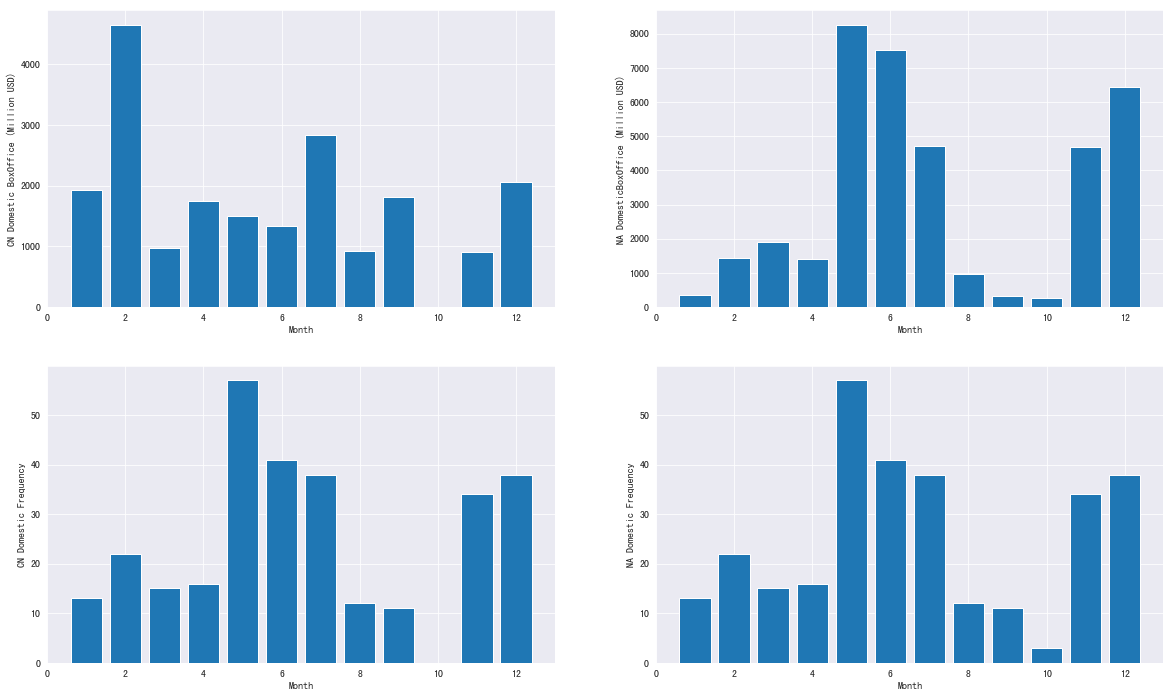

In [215]:
## show the plots for Monthly data between China & North America
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
ax[0][0].bar(x="Month", height="Month_money",data=dt_cn_month)
ax[0][0].set_ylabel('CN Domestic BoxOffice (Million USD)')
ax[0][0].set_xlabel('Month')

ax[0][1].bar(x="Month", height="Month_money",data=dt_na_month)
ax[0][1].set_ylabel('NA DomesticBoxOffice (Million USD)')
ax[0][1].set_xlabel('Month')

ax[1][0].bar(x="Month", height="Month_count",data=dt_cn_month)
ax[1][0].set_ylabel('CN Domestic Frequency')
ax[1][0].set_xlabel('Month')

ax[1][1].bar(x="Month", height="Month_count",data=dt_na_month)
ax[1][1].set_ylabel('NA Domestic Frequency')
ax[1][1].set_xlabel('Month')
plt.savefig('img/bar_month.png')

## Creating data sets for visulization of different genres

In [219]:
### change all the "dt_na" in the following codes to "dt_cn" and run again to get the comparison dataset for China
dt_g=dt_cn
dt_genre_box=dt_cn[["BoxOffice"]+list(unique_genere)]
for i in range(len(dt_genre_box.columns)):
    if i==0:
        continue
    for j in range(len(dt_genre_box.BoxOffice)):
        if dt_genre_box.iloc[j,i]==True:
            dt_genre_box.iloc[j,i]=dt_genre_box.iloc[j,0]
dt_genre_box_money=dt_genre_box[dt_genre_box.columns[1:]]
#
Genre=[]
Money=[]
Count=[]
for i in unique_genere:
    Genre.append(i)
    Money.append(dt_genre_box_money[i].sum())
    # change here
    Count.append(dt_cn[i].sum())
dt_genre_count=pd.DataFrame({"Genre":Genre,"Count":Count,"BoxOffice":Money})
#
Genre=[]
Money=[]
# change here
for i in range(len(dt_cn.BoxOffice)):
    for g in unique_genere:
        # change here
        if g in dt_cn.iloc[i,13]:
            Genre.append(g)
            Money.append(dt_cn.iloc[i,4])
dt_genre_count_seperate=pd.DataFrame({"Genre":Genre,"BoxOffice":Money})
dt_genre_count["Average"]=dt_genre_count.BoxOffice/dt_genre_count.Count
dt_genre_count=dt_genre_count.sort_values(by="Count")
dt_genre_count_seperate_list=[]
dt_genre_count_seperate_list_lab=[]
for g in dt_genre_count.Genre.unique():
    dt_genre_count_seperate_list_lab.append(g)
    dt_genre_count_seperate_list.append(dt_genre_count_seperate.BoxOffice[dt_genre_count_seperate.Genre==g].values.tolist())

## Creating plots for different Genres

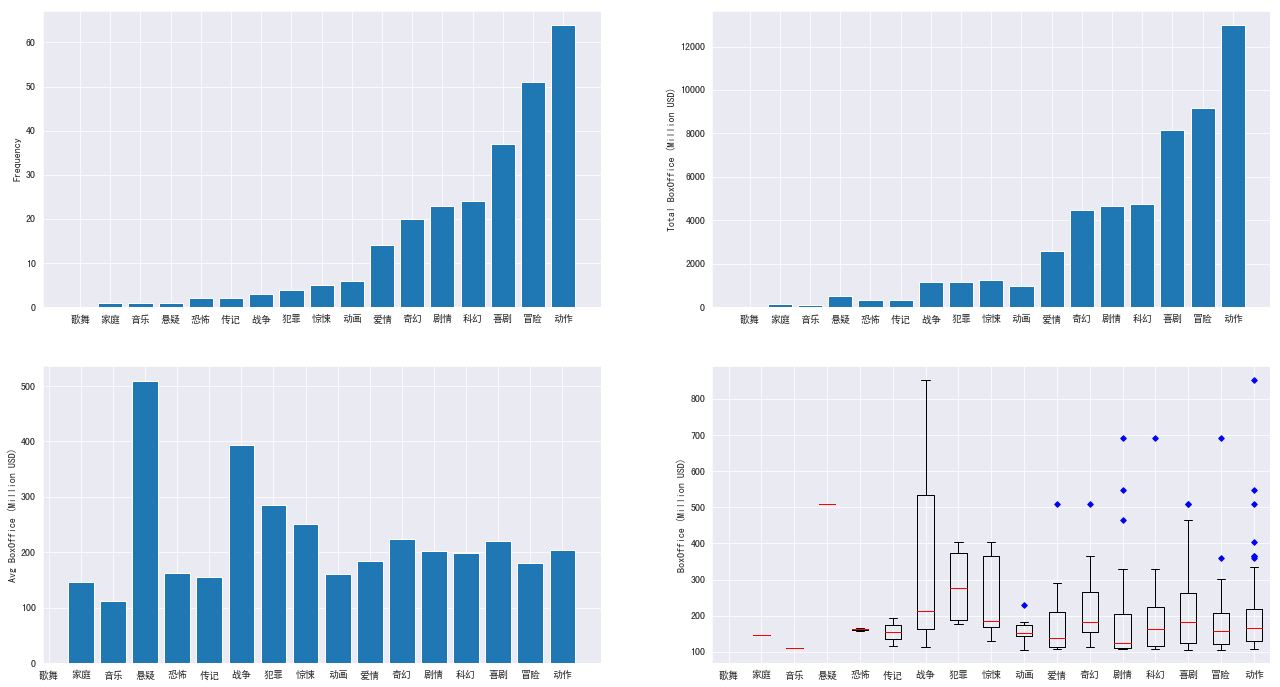

In [220]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,12))
ax[0][0].bar(x="Genre", height="Count",data=dt_genre_count)
ax[0][0].set_ylabel('Frequency')
ax[0][1].bar(x="Genre", height="BoxOffice",data=dt_genre_count)
ax[0][1].set_ylabel('Total BoxOffice (Million USD)')
ax[1][0].bar(x="Genre", height="Average",data=dt_genre_count)
ax[1][0].set_ylabel('Avg BoxOffice (Million USD)')
ax[1][1].boxplot(dt_genre_count_seperate_list,flierprops=dict(marker='D', markerfacecolor='b', markersize=4,markeredgecolor='b'),
                medianprops=dict(color='r'))
ax[1][1].set_ylabel("BoxOffice (Million USD)")
ax[1][1].set_xticklabels(dt_genre_count_seperate_list_lab)
plt.savefig('img/cn_genres.png')

In [223]:
dt_cn[dt_cn["爱情"]==True][dt_cn["喜剧"]==True]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Name,NameEng,MtimePage,ReleaseDate,BoxOffice,BoxOfficeDetail,BoxOfficeRankCN,BoxOfficeRankNA,BoxOfficeRankG,MtimeRating,...,动作,惊悚,动画,喜剧,悬疑,爱情,传记,战争,歌舞,奇幻
4,美人鱼,The Mermaid,http://movie.mtime.com/209007,2016-02-08,508.80,首日2.72亿|首周18.18亿|连冠2周,5,0,0,7.4,...,False,False,False,True,False,True,False,False,False,True
16,前任3：再见前任,The Ex-File: The Return of the Exes,http://movie.mtime.com/230788,2017-12-29,291.30,首日6449.1万|首周2.81亿,17,0,0,6.5,...,False,False,False,True,False,True,False,False,False,False
28,夏洛特烦恼,Goodbye Mr.Loser,http://movie.mtime.com/218763,2015-09-30,216.30,首日2326.6万|首周2.58亿,29,0,0,7.7,...,False,False,False,True,False,True,False,False,False,False
46,心花路放,Breakup Buddies,http://movie.mtime.com/206162,2014-09-30,174.75,首日1.03亿,47,0,0,7.3,...,False,False,False,True,False,True,False,False,False,False
76,从你的全世界路过,Belonged To You,http://movie.mtime.com/219178,2016-09-29,122.10,首日7409.1万|首周3.10亿,77,0,0,5.5,...,False,False,False,True,False,True,False,False,False,False
84,大闹天竺,Buddies In India,http://movie.mtime.com/225095,2017-01-28,113.70,首日1.89亿|首周3.07亿,85,0,0,5.9,...,False,False,False,True,False,True,False,False,False,False
92,西游记女儿国,The Monkey King 3,http://movie.mtime.com/209205,2018-02-16,109.05,首日1.64亿|首周3.25亿,93,0,0,5.4,...,True,False,False,True,False,True,False,False,False,False


# Some exploration on the data for basic information

In [253]:
dt_global_unique=dt.drop_duplicates(subset=("Name","BoxOfficeGlobal")).sort_values(by="BoxOfficeGlobal",ascending=False)
dt_global_unique.to_csv("data/global_unique.csv")
dt_global_unique.describe()

,BoxOffice,BoxOfficeRankCN,BoxOfficeRankNA,BoxOfficeRankG,MtimeRating,NumberofReviewers,BoxOfficeGlobal,Runtime,Year,Month
count,202.000000,202.000000,202.000000,202.00000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,490.003465,25.074257,25.277228,25.00000,7.514356,13392.658416,614.350743,125.707921,2012.158416,6.539604
std,366.782097,32.443896,32.508742,32.48421,0.762127,15314.534284,461.519056,21.159871,7.346753,3.415055
min,106.500000,0.000000,0.000000,0.00000,4.700000,148.000000,106.500000,85.000000,1977.000000,1.000000
25%,172.312500,0.000000,0.000000,0.00000,7.200000,4587.750000,196.650000,110.000000,2010.000000,4.000000
50%,310.000000,0.500000,0.500000,0.00000,7.600000,9392.500000,620.325000,125.000000,2015.000000,6.000000
75%,822.000000,49.750000,50.750000,49.75000,8.000000,17155.500000,895.500000,140.000000,2017.000000,9.000000
max,1519.000000,100.000000,100.000000,100.00000,9.100000,118992.000000,2788.000000,201.000000,2019.000000,12.000000


## You can directly show the minmal or maximum for each data set based on sales/ratings

In [254]:
dt_global_unique[dt_global_unique.MtimeRating==min(dt_global_unique.MtimeRating)]

,Name,NameEng,MtimePage,ReleaseDate,BoxOffice,BoxOfficeDetail,BoxOfficeRankCN,BoxOfficeRankNA,BoxOfficeRankG,MtimeRating,...,动作,惊悚,动画,喜剧,悬疑,爱情,传记,战争,歌舞,奇幻
51,澳门风云3,From Vegas To Macau,http://movie.mtime.com/222326,2016-02-08,167.7,首日1.76亿|首周7.87亿,52,0,0,4.7,...,True,False,False,True,False,False,False,False,False,False


In [255]:
dt_global_unique[dt_global_unique.MtimeRating==max(dt_global_unique.MtimeRating)]

,Name,NameEng,MtimePage,ReleaseDate,BoxOffice,BoxOfficeDetail,BoxOfficeRankCN,BoxOfficeRankNA,BoxOfficeRankG,MtimeRating,...,动作,惊悚,动画,喜剧,悬疑,爱情,传记,战争,歌舞,奇幻
168,盗梦空间,Inception,http://movie.mtime.com/99547,2010-07-16,828.0,NaN,0,84,69,9.1,...,True,False,False,False,False,False,False,False,False,False
258,阿甘正传,Forrest Gump,http://movie.mtime.com/10054,1994-06-23,330.0,NaN,0,59,0,9.1,...,False,False,False,False,False,True,False,False,False,False


## Potential relationship between ratings & sales

In [281]:
## data scaling:
rate_sale=dt_global_unique.iloc[:,9:12]
rate_sale.NumberofReviewers=rate_sale.NumberofReviewers.apply(lambda x: \
         (x-min(rate_sale.NumberofReviewers))/(max(rate_sale.NumberofReviewers)-min(rate_sale.NumberofReviewers)))
rate_sale.MtimeRating=rate_sale.MtimeRating.apply(lambda x: \
         (x-min(rate_sale.MtimeRating))/(max(rate_sale.MtimeRating)-min(rate_sale.MtimeRating)))
rate_sale.BoxOfficeGlobal=rate_sale.BoxOfficeGlobal.apply(lambda x: \
         (x-min(rate_sale.BoxOfficeGlobal))/(max(rate_sale.BoxOfficeGlobal)-min(rate_sale.BoxOfficeGlobal)))

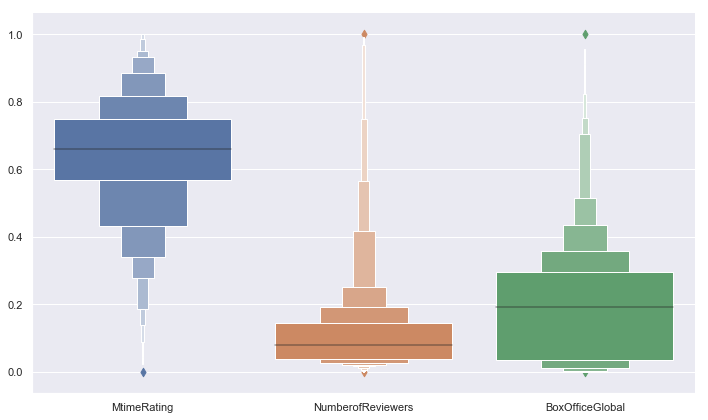

In [290]:
box_plot=sns.catplot(data=rate_sale,kind="boxen",height=6, aspect=10/6)
box_plot.savefig("img/boxen_rate.png")

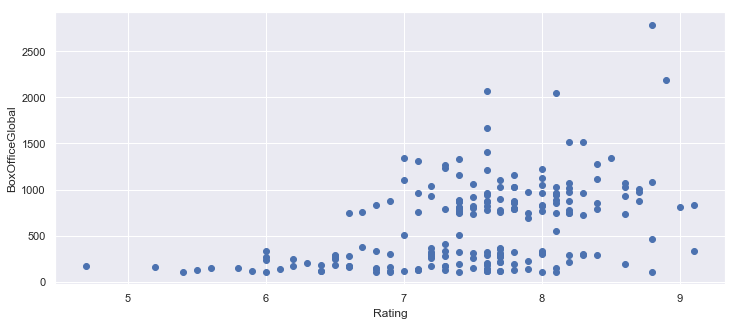

In [296]:
f, ax = plt.subplots(figsize=(12,5))
#ax.scatter(x="MtimeRating", y="BoxOffice",data=dt_cn)
ax.scatter("MtimeRating", "BoxOfficeGlobal",data=dt_global_unique)
ax.set_xlabel("Rating")
ax.set_ylabel("BoxOfficeGlobal")
plt.savefig("img/scatter_rate_sale.png")

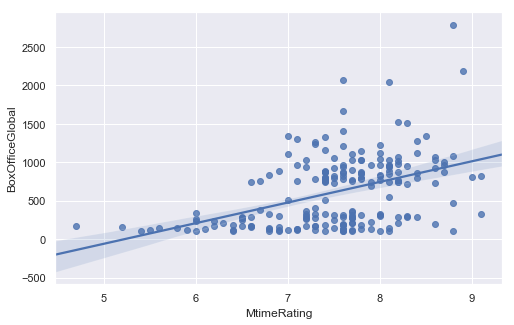

In [298]:
f, ax = plt.subplots(figsize=(8,5))
sns.regplot(x="MtimeRating", y="BoxOfficeGlobal", data=dt_global_unique)

## Shinning Stars in China

In [54]:
## see the lists of staff all scraped 
[i for i in dt_cn.ActorAndStaff.apply(lambda x: pd.Series(x)).columns]

['演员 Actor',
 '导演 Director',
 '编剧 Writer',
 '制作人 Produced by',
 '摄影 Cinematography',
 '剪辑 Film Editing',
 '原创音乐 Original Music',
 '美术设计 Art Direction by',
 '动作指导 Choreographer',
 '视觉特效 Visual Effects Supervisor',
 '声音部门 Sound Department',
 '化妆造型 Makeup Department',
 '服装设计 Costume Design by',
 '副导演/助理导演 Assistant Director',
 '艺术指导 Production Designer',
 '布景师 Set Decoration by',
 '选角导演 Casting',
 '录音 Sound recordist',
 '动画导演 animation director']

In [214]:
### get individual data for sales of actors 
for i in range(4):
    actor=dt_na.ActorAndStaff.apply(lambda x: pd.Series(x['演员 Actor'][i:i+1]))
    dt_na_actor=pd.merge(left=dt_na[dt_na.columns[0:5]],right=actor,
                     right_index=True,left_index=True)
    if i==0:
        dt_na_actor_final=dt_na_actor
    else:
        dt_na_actor_final=dt_na_actor_final.append(dt_na_actor)
dt_na_actor_final=dt_na_actor_final.reset_index(drop=True).dropna()
dt_na_actor_final.rename(columns={0: 'Actor'}, inplace=True)
dt_na_actor_final.to_csv("data/na_actor.csv")

In [157]:
dt_na_actor_final.groupby(['Actor']).sum().sort_values(by="BoxOffice",ascending=False)

,BoxOffice
Actor,
小罗伯特·唐尼 Robert Downey Jr.,3542.0
艾玛·沃森 Emma Watson,2383.0
哈里森·福特 Harrison Ford,2314.0
克里斯·埃文斯 Chris Evans,2169.0
克里斯·海姆斯沃斯 Chris Hemsworth,2076.0
斯嘉丽·约翰逊 Scarlett Johansson,2072.0
丹尼尔·雷德克里夫 Daniel Radcliffe,1879.0
鲁伯特·格林特 Rupert Grint,1879.0
克里斯·帕拉特 Chris Pratt,1793.0


In [154]:
dt_cn_actor_final['Actor'].value_counts()

黄渤 Bo Huang                   6
徐峥 Zheng Xu                   6
王宝强 Baoqiang Wang             5
白百何 Fay Bai                   5
成龙 Jackie Chan                5
沈腾 Teng Shen                  5
小罗伯特·唐尼 Robert Downey Jr.     5
郭富城 Aaron Kwok                4
井柏然 Boran Jing                4
周润发 Yun-Fat Chow              4
克里斯·埃文斯 Chris Evans           4
范·迪塞尔 Vin Diesel              3
甄子丹 Donnie Yen                3
张涵予 Hanyu Zhang               3
邓超 Chao Deng                  3
克里斯·海姆斯沃斯 Chris Hemsworth     3
斯嘉丽·约翰逊 Scarlett Johansson    3
舒淇 Hsu Chi                    3
道恩·强森 Dwayne Johnson          3
杰森·斯坦森 Jason Statham          3
韩庚 Geng Han                   2
克里斯·帕拉特 Chris Pratt           2
小沈阳 Xiao Shenyang             2
冯绍峰 Shaofeng Feng             2
马克·沃尔伯格 Mark Wahlberg         2
李冰冰 Bingbing Li               2
本·金斯利 Ben Kingsley            2
赵丽颖 Liying Zhao               2
罗志祥 Show Lo                   2
柳岩 Ada                        2
                             ..
约翰·古德曼 J

In [182]:
set(dt_cn[:10].Name.values) & set(dt_na.Name.values)

{'速度与激情7'}

In [183]:
set(dt_na[:10].Name.values) & set(dt_cn.Name.values)

{'侏罗纪世界', '复仇者联盟3：无限战争', '星球大战：原力觉醒', '泰坦尼克号', '阿凡达'}